# Péndulo Doble
Para el punto 3, hallaremos usando `smypy` las ecuaciones de movimiento del péndulo invertido, para luego resolverlas numéricamente usando de `scipy.integrate` el método `odeint` (RK4). 

In [43]:
# Importe de librerías
import numpy as np
import sympy as smp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter

from sympy.physics.mechanics import *
init_vprinting(pretty_print=True)

## Solución numérica sin linealización
Inicialmente definimos las variables independientes, según el dibujo :)

In [44]:
t, g, m1, m2, L1, L2 = smp.symbols('t, g, m_1, m_2, L_1, L_2')

$\theta_1$ and $\theta_2$ son functions del tiempo, para las cuales solucionaremos las EDOs más adelante.

In [45]:
th1, th2 = smp.symbols(r'\theta_1, \theta_2', cls=smp.Function)
th1 = th1(t)
th2 = th2(t)

th1

También definimos las primeras y segundas derivadas de ambos ángulos.

In [46]:
# Derivadas de las coordenadas angulares
dth1 = smp.diff(th1, t)
dth2 = smp.diff(th2, t)
d2th1 = smp.diff(dth1, t)
d2th2 = smp.diff(dth2, t)

d2th2

También definimos $x_1$, $y_1$, $x_2$, y $y_2$ en términos de los ángulos $\theta_1$ y $\theta_2$, para poder hacer la animación más adelante y para calcular fácilmente las energías del sistema.

Las coordenadas cartesianas a partir de las coordenadas polares definidas en la imagen arriba se pueden calcular como, para la primera masa:

$$x_1 = L_1 \sin(\theta_1)$$
$$y_1 = -L_1 \cos(\theta_1)$$

mientras que, para la segunda masa son:

$$ x_2 = L_1 \sin(\theta_1) + L_2 \sin(\theta_2) $$
$$ y_2 = -L_1 \cos(\theta_1) - L_2 \cos(\theta_2) $$

In [47]:
# Coordenadas cartesianas
x1 = L1*smp.sin(th1)
y1 = -L1*smp.cos(th1)
x2 = L1*smp.sin(th1)+L2*smp.sin(th2)
y2 = -L1*smp.cos(th1)-L2*smp.cos(th2)

Para las hallar las dos ecuaciones de Euler-Lagrange (ecuaciones EL), debemos hallar el lagrangiano $L=T-V$ en términos de las coordenadas $\theta_i$ y las velocidades angulares $\omega_i := \dot{\theta}_i$.

En particular, la energía cinética del sistema es la suma de las energías cinéticas de ambas masas:

$$ T = T_1 + T_2 = \frac{1}{2} m_1 (\dot{x_1}^2 + \dot{y_1}^2) + \frac{1}{2} m_2 (\dot{x_2}^2 + \dot{y_2}^2) $$ 

Mientras que, definiendo el cero de energía potencial en como se muestra en la figura, la energía potencial del sistema es:

$$ V = V_1 + V_2 = m_1 g y_1 + m_2 g y_2$$

In [48]:
# Cinética
T1 = smp.Rational(1,2) * m1 * (smp.diff(x1, t)**2 + smp.diff(y1, t)**2)
T2 = smp.Rational(1,2) * m2 * (smp.diff(x2, t)**2 + smp.diff(y2, t)**2)
T = T1+T2
# Potencial
V1 = m1*g*y1
V2 = m2*g*y2
V = V1 + V2
# Lagrangiano
L = T-V

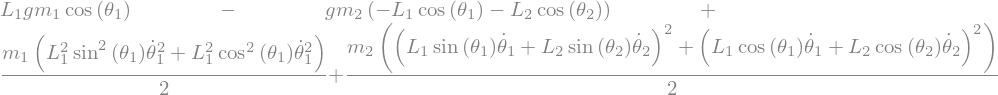

In [49]:
L

Ahora, las ecuaciones EL (que son dos, porque hay dos cuerpos), se hallan usando la condición necesaria de optimalidad de primer orden como se muestra a continuación:

$$\frac{\partial L}{\partial \theta_1} - \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_1}} = 0$$
$$\frac{\partial L}{\partial \theta_2} - \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_2}} = 0$$

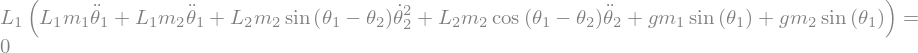

In [50]:
# Ecuaciones EL
EL1 = smp.Eq(smp.diff(L, th1) - smp.diff(smp.diff(L, dth1), t), 0)
EL2 = smp.Eq(smp.diff(L, th2) - smp.diff(smp.diff(L, dth2), t), 0)

EL1.simplify()

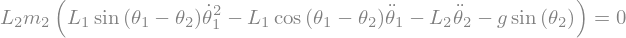

In [51]:
EL2.simplify()

Notemos que ambas ecuaciones EL son lineales en las segundas derivadas de $\theta_1$ y $\theta_2$. Para la aplicación de `odeint` requerimos despejar estas derivadas de segundo orden.

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman


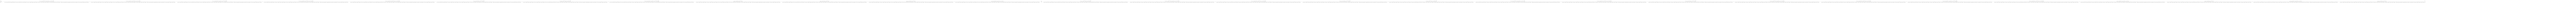

In [52]:
sols = smp.solve([EL1, EL2], (d2th1, d2th2), simplify=False, rational=False)
sols

Ahora, `sols` es un diccionario que contiene dos ecuaciones de la forma:

* $\frac{d^2 \theta_1}{dt^2} = ...$
* $\frac{d^2 \theta_2}{dt^2} = ...$

Que son dos EDOs de segundo orden. En python solo se pueden solucionar sistemas de EDOs de primer orden. No obstante, cualquier ecuación de segundo orden se puede reducir a dos ecuaciones de primer orden aplicando el siguiente truco:

1. Se define $z_1 = d\theta_1/dt$ y $z_2=d\theta_2/dt$
2. Luego, se tiene que $dz_1/dt = d^2\theta_1/dt^2$ y $dz_2/dt = d^2\theta_2/dt^2$

De modo que, aplicando este truco, obtenemos un sistema de cuatro ecuaciones de primer orden:

* $d z_1/dt = ...$
* $d\theta_1/dt = z_1$
* $d z_2/dt = ...$
* $d\theta_2/dt = z_1$

Ahora, dado que hasta ahora tenemos ecuaciones simbólicas de python, necesitamos convertir estas expresiones a funciones numéricas instanciables para meterlas en el solver `odeint`. Para ello usamos `smp.lambdify` como se muestra:

In [53]:
# Conversión de expresiones simbólicas a funciones
dz1dt_f = smp.lambdify((t,g,m1,m2,L1,L2,th1,th2,dth1,dth2), sols[d2th1])
dz2dt_f = smp.lambdify((t,g,m1,m2,L1,L2,th1,th2,dth1,dth2), sols[d2th2])
dthe1dt_f = smp.lambdify(dth1, dth1)
dthe2dt_f = smp.lambdify(dth2, dth2)

Ahora, debemos definir $\vec{S} = (\theta_1, z_1, \theta_2, z_2)$. Si vamos a usar un solver en python, necesitamos crear una función que tome el vector $\vec{S}$ y el tiempo $t$ and y retorne $d\vec{S}/dt$. En otras palabras, debemos definir $d\vec{S}/dt (\vec{S}, t)$.

Así, nuestro sistema de EDOs viene completamente especificado por $d\vec{S}/dt$ y depende solo de $\vec{S}$ y $t$.

In [54]:
def dSdt(S, t, g, m1, m2, L1, L2):
    the1, z1, the2, z2 = S
    return [
        dthe1dt_f(z1),
        dz1dt_f(t, g, m1, m2, L1, L2, the1, the2, z1, z2),
        dthe2dt_f(z2),
        dz2dt_f(t, g, m1, m2, L1, L2, the1, the2, z1, z2),
    ]

Finalmente, antes de resolver el sistema de EDOS, necesitamos especificar las condiciones iniciales del sistema. El vector de condiciones iniciales tiene la forma:

$$\text{ics} = \begin{pmatrix} \theta_1 \\ \dot{\theta_1} \\ \theta_2 \\ \dot{\theta_2} \end{pmatrix}$$

In [55]:
ics = [1, -3, -1, 5]

Y finalmente, resolvemos el sistema de EDOs usando `odeint` en el intervalo $t \in [0,40]$, con los parámetros especificados.

In [56]:
t_v = np.linspace(0, 40, 1001)
g_v = 9.81
m1_v = 2
m2_v = 1
L1_v = 2
L2_v = 1
ans = odeint(dSdt, y0=ics, t=t_v, args=(g_v, m1_v, m2_v, L1_v, L2_v))

In [57]:
ans.T

array([[ 1.        ,  0.87413906,  0.73333306, ..., -2.31463074,
        -2.24850799, -2.17564881],
       [-3.        , -3.31025173, -3.75998052, ...,  1.56994266,
         1.73675527,  1.90667234],
       [-1.        , -0.78277685, -0.52139856, ..., 63.28370317,
        63.3690498 , 63.45562577],
       [ 5.        ,  5.91440903,  7.24155048, ...,  2.10721111,
         2.15466582,  2.16829557]])

Can obtain $\theta_1(t)$ and $\theta_2(t)$ from the answer

In [58]:
th1_v = ans.T[0]
dth1_v = ans.T[1]
th2_v = ans.T[2]
dth2_v = ans.T[3]

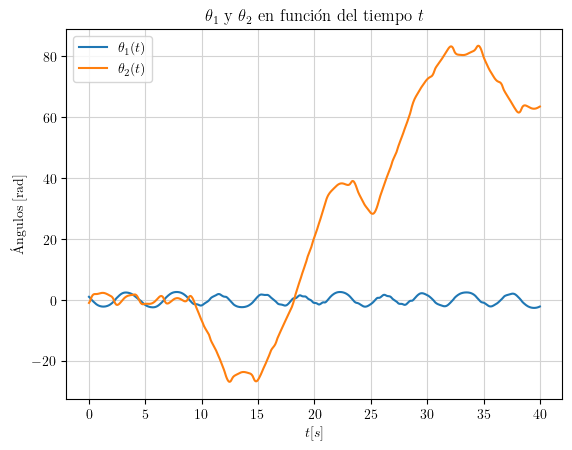

In [59]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"]
})

plt.figure()

plt.plot(t_v, th1_v, label=r'$\theta_1(t)$')
plt.plot(t_v, th2_v, label=r'$\theta_2(t)$')


plt.xlabel(r'$t [s]$')
plt.ylabel(r'Ángulos [rad]')
plt.title(r'$\theta_1$ y $\theta_2$ en función del tiempo $t$')
plt.legend()

plt.grid(True, color='lightgray')
plt.show()


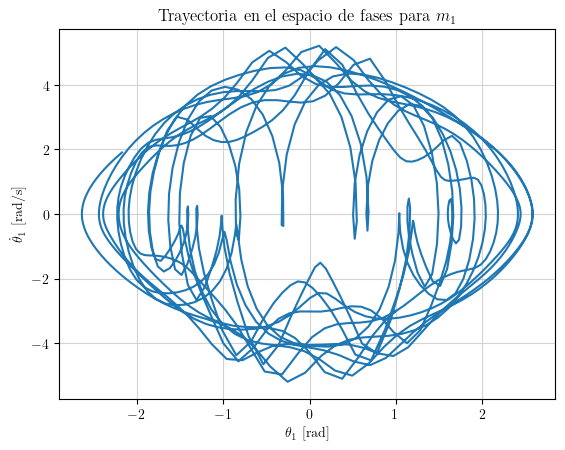

In [60]:
# Gráfica en el espacio de fases
plt.figure()

plt.plot(th1_v, dth1_v)

plt.xlabel(r'$\theta_1$ [rad]')
plt.ylabel(r'$\dot{\theta}_1$ [rad/s]')
plt.title(r'Trayectoria en el espacio de fases para $m_1$')

plt.grid(True, color='lightgray')
plt.show()


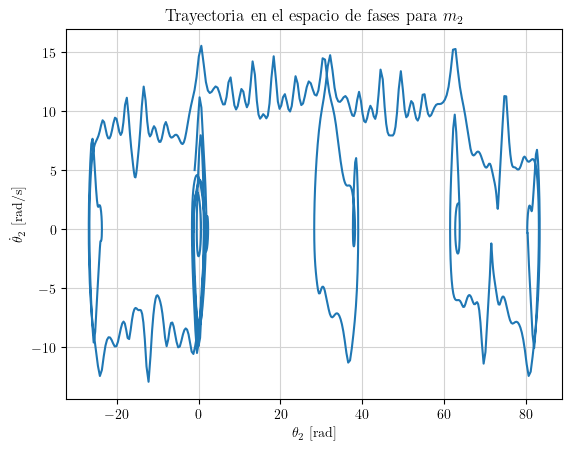

In [61]:
# Gráfica en el espacio de fases
plt.figure()

plt.plot(th2_v, dth2_v)

plt.xlabel(r'$\theta_2$ [rad]')
plt.ylabel(r'$\dot{\theta}_2$ [rad/s]')
plt.title(r'Trayectoria en el espacio de fases para $m_2$')

plt.grid(True, color='lightgray')
plt.show()


Por último, para hacer una animación de la dinámica del sistema, creamos una función que toma $\theta_1$ y $\theta_2$ y retorna la locación $(x,y)$ de ambas masas.

In [62]:
def get_cartesian(t, the1, the2, L1, L2):
    return (L1_v * np.sin(the1),
            -L1_v * np.cos(the1),
            L1_v * np.sin(the1) + L2_v * np.sin(the2),
            -L1_v * np.cos(the1) - L2_v * np.cos(the2))

x1_v, y1_v, x2_v, y2_v = get_cartesian(t_v, th1_v, th2_v, L1_v, L2_v)

Y luego creamos una animación!

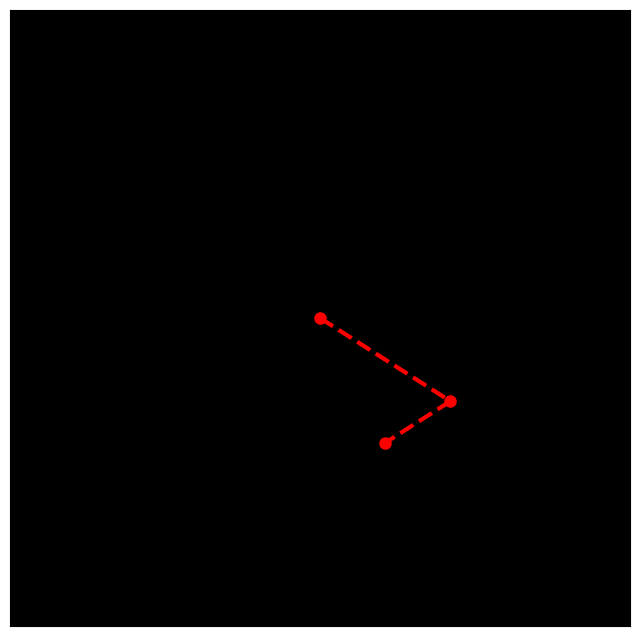

In [63]:
'''def animate(i):
    ln1.set_data([0, x1_v[i], x2_v[i]], [0, y1_v[i], y2_v[i]])
    
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.set_facecolor('k')
ax.get_xaxis().set_ticks([])    
ax.get_yaxis().set_ticks([])
ln1, = plt.plot([], [], 'ro--', lw=3, markersize=8)
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('animacion-pendulo-doble.gif',writer='pillow',fps=25)'''

# Linealización

In [66]:
lin = {smp.sin(th1) : th1, smp.cos(th1) : 1, smp.sin(th2) : th2, smp.cos(th2) : 1,
       dth1**2 : 0, dth2**2 : 0}

In [71]:
# Posiciones linealizadas
x1_l = x1.subs(lin)
y1_l = x1.subs(lin)

x2_l = x2.subs(lin)
y2_l = y2.subs(lin)

y2_l

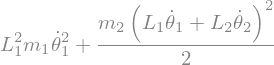

In [72]:
# Cinética
T1_l = smp.Rational(1,2) * m1 * (smp.diff(x1_l, t)**2 + smp.diff(y1_l, t)**2)
T2_l = smp.Rational(1,2) * m2 * (smp.diff(x2_l, t)**2 + smp.diff(y2_l, t)**2)
T_l = T1_l + T2_l

T_l

In [ ]:
# Cinética
T1 = smp.Rational(1,2) * m1 * (smp.diff(x1, t)**2 + smp.diff(y1, t)**2)
T2 = smp.Rational(1,2) * m2 * (smp.diff(x2, t)**2 + smp.diff(y2, t)**2)
T = T1+T2
# Potencial
V1 = m1*g*y1
V2 = m2*g*y2
V = V1 + V2
# Lagrangiano
L = T-V